In [1]:
from google.cloud import bigquery
import os
import pandas as pd

In [2]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../../oso_gcp_credentials.json'
GCP_PROJECT = 'opensource-observer'
client = bigquery.Client(GCP_PROJECT)

In [3]:
results = client.query("""
    SELECT
        EXTRACT(MONTH FROM DATETIME(TIMESTAMP(e.time), "America/New_York")) AS month,
        EXTRACT(DAY FROM DATETIME(TIMESTAMP(e.time), "America/New_York")) AS day_number,
        EXTRACT(DAYOFWEEK FROM DATETIME(TIMESTAMP(e.time), "America/New_York")) AS day_of_week,
        EXTRACT(HOUR FROM DATETIME(TIMESTAMP(e.time), "America/New_York")) AS hour,
        SUM(e.amount) AS amount
    FROM `oso_production.int_events__github` AS e
    JOIN `oso_production.users_v1` AS u
        ON e.from_artifact_id = u.user_id
    WHERE u.display_name = 'ccerv1'
    GROUP BY 1, 2, 3, 4
    ORDER BY 1, 2, 4
""")
df = results.to_dataframe()
df.tail()

,month,day_number,day_of_week,hour,amount
1907,12,26,5,11,4.0
1908,12,27,4,7,1.0
1909,12,27,6,9,2.0
1910,12,28,7,13,1.0
1911,12,28,7,14,4.0


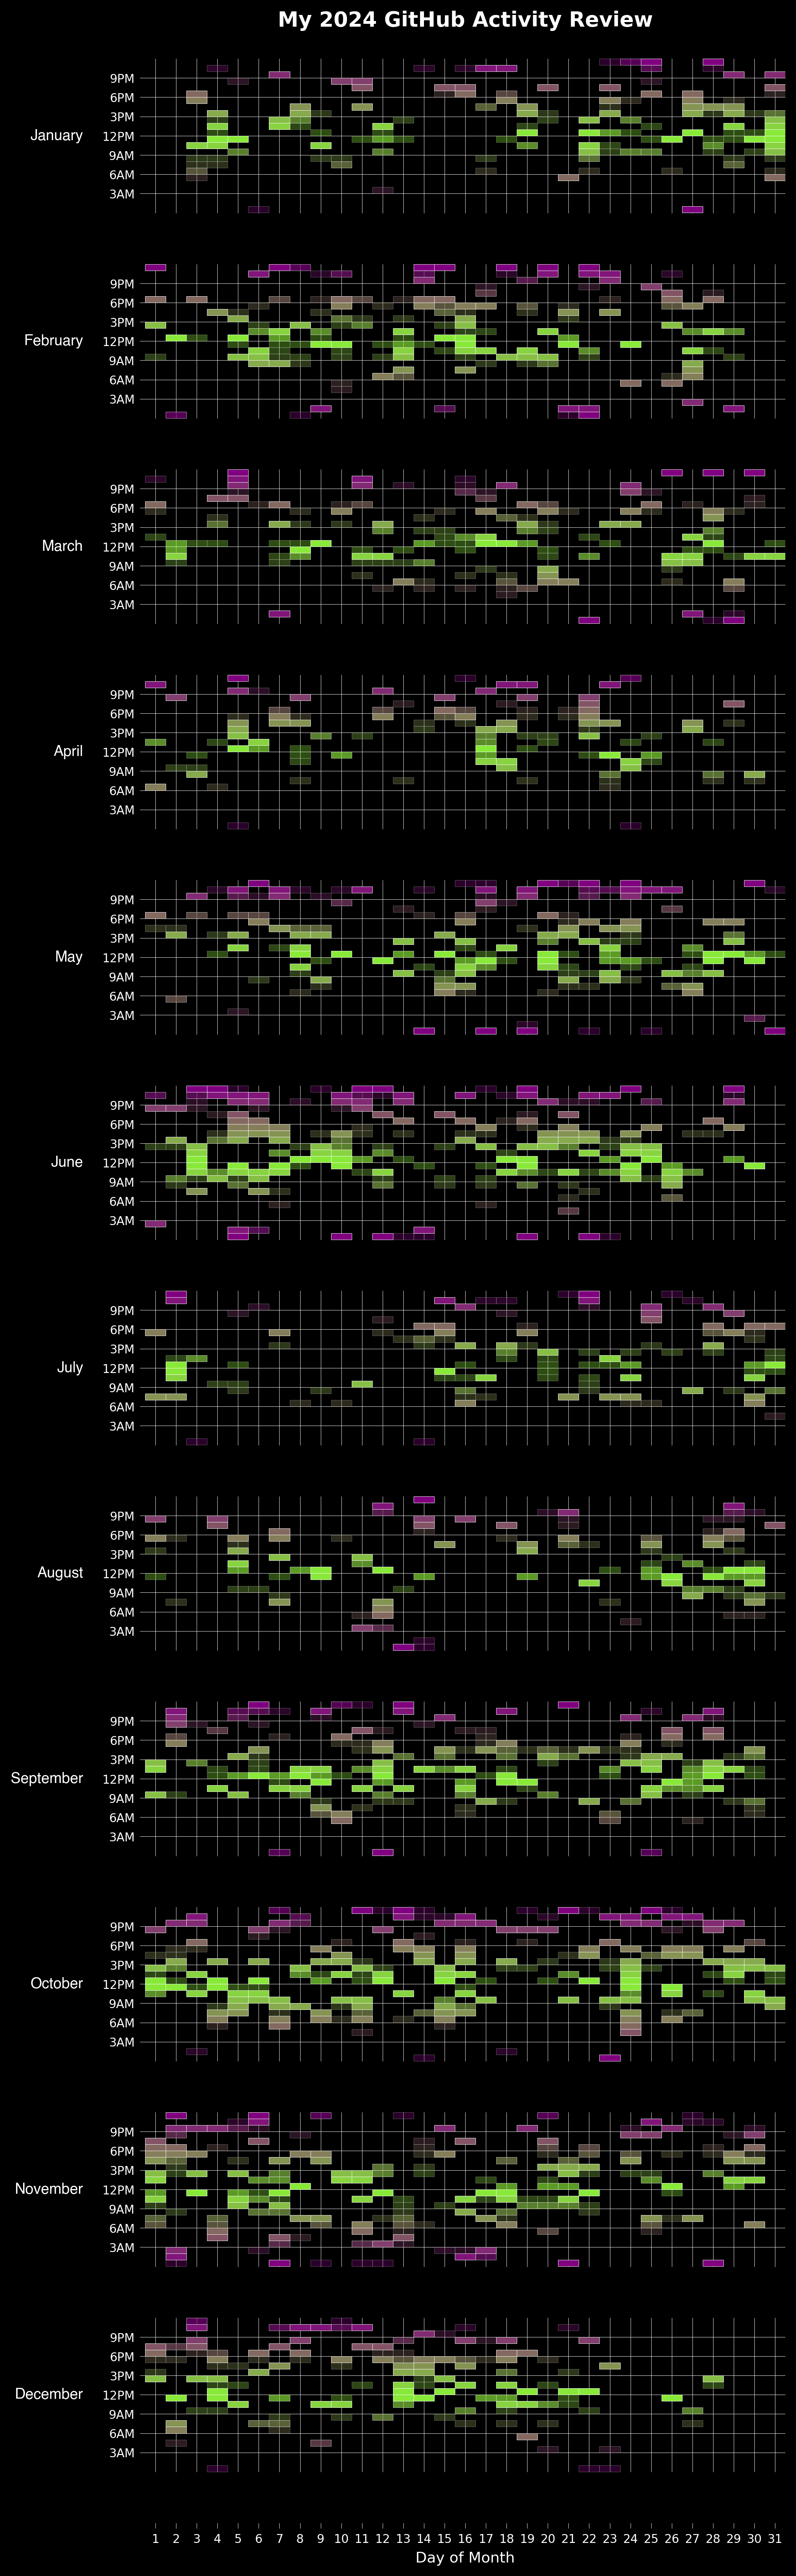

In [4]:
from datetime import date, timedelta
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Plot setup
HEIGHT = 30
DPI = 300
fig, ax = plt.subplots(figsize=(HEIGHT // 2, HEIGHT), dpi=DPI)
plt.rcParams['font.family'] = 'Helvetica'

# Colormap: Purple to Green
purple = (128/255, 0/255, 128/255)   # "purple"
green = '#89f336'                    # "green"
hour_cmap = LinearSegmentedColormap.from_list("hour_cmap", [purple, green, purple])

# Set black background
fig.patch.set_facecolor("black")
ax.set_facecolor("black")

# Match ticks to gridline style
ax.tick_params(axis='both', colors='white', width=0.25)

# Spacing parameters
max_amount = 3
month_padding = 8  # Space between rows (in data units)
square_width = 1    # Size of each square in data units

month_names = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

# Date range loop
year = 2024
start_date = date(year, 1, 1)
end_date = date(year, 12, 31)
current_date = start_date

while current_date <= end_date:
    month = current_date.month
    day = current_date.day
    current_date += timedelta(days=1)

    # Calculate Y-offset for the current month
    y_offset = (11 - (month - 1)) * (24 + month_padding) + month_padding / 2

    # Add a black rectangle between months
    rect_y_bottom = y_offset - month_padding
    black_rect = plt.Rectangle(
        (0, rect_y_bottom),      # Bottom-left corner
        31 * square_width,       # Width (entire month width)
        month_padding*.99,       # Height (spacing height)
        facecolor="black",
        edgecolor="none"
    )
    ax.add_patch(black_rect)

    for hour in range(0, 24):
        dff = df[(df['month'] == month) & (df['day_number'] == day) & (df['hour'] == hour)]
        if dff.empty:
            amount = 0
        else:
            amount = dff['amount'].sum()

        color = hour_cmap(hour / 23)  # Normalize hour (0-23) to colormap range (0-1)
        alpha = 1.0 if amount >= max_amount else amount / max_amount

        # Determine rectangle color (black for no activity)
        rect_color = color if amount > 0 else "black"

        # Bottom-left corner of the rectangle
        x_left = (day - 1) * square_width
        y_bottom = y_offset + hour * square_width

        # Draw the rectangle
        rect = plt.Rectangle(
            (x_left, y_bottom),    # Bottom-left corner
            square_width,          # Width of the rectangle
            square_width,          # Height of the rectangle
            facecolor=rect_color,
            alpha=alpha,
            edgecolor="white",
            lw=.25
        )
        ax.add_patch(rect)

# Axis limits
ax.set_xlim(0, 31 * square_width)  # Days of the month
ax.set_ylim(-month_padding / 2, 12 * (24 + month_padding) - month_padding / 2)  # Remove extra top/bottom rows

# Add month annotations on the left of the plot
for i, month_name in enumerate(month_names):
    y_position = (11 - i) * (24 + month_padding) + month_padding * 2
    ax.text(
        s=month_name,
        x=-3,
        y=y_position,
        ha='right',
        va='center',
        fontsize=10,
        weight='bold',
        color="white"  # Set text color to white
    )

# Adjust layout to allow space for the month labels
plt.subplots_adjust(left=0.5)  # Increase the left margin significantly

# Add X-ticks for days of the month
xticks = [x + 0.5 for x in range(0, 31)]
ax.set_xticks(xticks)
ax.set_xticklabels([str(x) for x in range(1, 32)], fontsize=8, color="white")

# Add Y-ticks for specific hours in each day
y_ticks = []
y_tick_labels = []
for i, month_name in enumerate(month_names):
    base_y = (11 - i) * (24 + month_padding) + month_padding / 2
    for hour, label in zip([3, 6, 9, 12, 15, 18, 21], ["3AM", "6AM", "9AM", "12PM", "3PM", "6PM", "9PM"]):
        y_ticks.append(base_y + hour * square_width)
        y_tick_labels.append(label)

ax.set_yticks(y_ticks)
ax.set_yticklabels(y_tick_labels, fontsize=8, color="white")

# Add axis labels and title
ax.set_xlabel("Day of Month", color="white")
ax.set_ylabel("", color="white")
ax.grid(visible=True, color='white', linestyle='-', linewidth=0.25)
ax.set_axisbelow(True)

for spine in ax.spines.values():
    spine.set_visible(False)

plt.title("My 2024 GitHub Activity Review\n", fontsize=14, weight='bold', color="white")
plt.show()